In [ ]:
import chess
import numpy as np
piece_to_idx = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

letters = ["a", "b", "c", "d", "e", "f", "g", "h"]
numbers = list(range(1, 10)) # [1..9]
MOVE_DICTIONARY = {}
cumulative = 0
for row in range(8):
    for col in range(8):
        for k in range(8):
            for w in range (8):
                if (row == k and col == w):
                    cumulative += 1
                    continue
                from_square = f"{letters[row]}{numbers[col]}"
                to_square = f"{letters[k]}{numbers[w]}"
                MOVE_DICTIONARY[f"{from_square}{to_square}"] = (row * 8**3) + (col * 8**2) + (k * 8) + w - cumulative
REVERSE_MOVE_DICTIONARY = {
    value: key for key,value in MOVE_DICTIONARY.items()
}

def board_to_tensor(board: chess.Board):
    tensor = np.zeros((12, 8, 8), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            tensor[piece_to_idx[piece.symbol()]][square // 8][square % 8] = 1
    side_channel = np.ones((1, 8, 8)) if board.turn == chess.WHITE else np.zeros((1, 8, 8))
    tensor = np.concatenate((tensor, side_channel), axis=0)
    return tensor



MODEL_WEIGHTS = './models/CompleteModel_Epoch-75R.pth'

In [2]:
import torch
from torch import nn
class CompleteChessBotNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 13 channels: 12 pieces + side to play (tensor[true's|false's])
        self.conv1 = nn.Conv2d(13,64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, 64 * 63) # (Choose 2 squares from the board where the order matters) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, x):
        x = self.sigmoid(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = CompleteChessBotNetwork().to(device)
trained_model.load_state_dict(torch.load(MODEL_WEIGHTS))
trained_model.eval()  # Set model to evaluation mode

def predict_move(bitmaps):
    bitmaps  = np.expand_dims(bitmaps, axis=0)
    X_tensor = torch.tensor(bitmaps, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        logits = trained_model(X_tensor)
    
    logits = logits.squeeze(0)  # Remove batch dimension
    
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    
    return probabilities

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping of piece letters to unicode chess symbols
PIECE_UNICODE = {
    'P': '♙', 'N': '♘', 'B': '♗', 'R': '♖', 'Q': '♕', 'K': '♔',
    'p': '♟︎', 'n': '♞', 'b': '♝', 'r': '♜', 'q': '♛', 'k': '♚'
}

def plot_board(board: chess.Board, move_probs=None):
    colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]
    _, ax = plt.subplots(figsize=(8, 8))

    # Draw squares
    for row in range(8):
        for col in range(8):
            color = colors[(row + col) % 2]
            rect = plt.Rectangle((col, 7-row), 1, 1, facecolor=color)
            ax.add_patch(rect)
            if ((piece := board.piece_at(chess.square(row, col))) is not None):
                piece_unicode = piece.unicode_symbol()
                ax.text(row + 0.5, col + 0.5, piece_unicode, fontsize=48, ha='center', va='center')


    # Add a-h and 1-8 labels
    # files = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
    for row in range(8):
        # Bottom labels
        ax.text(row + 0.5, -0.3, files[row], ha='center', va='center', fontsize=14)
        # Left side labels
        ax.text(-0.3, row + 0.5, ranks[7-row], ha='center', va='center', fontsize=14)

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [4]:
# probabilities = predict_move(bitmaps)  # model output
# print(probabilities)

# # Recebmos as classes dos moves: converter para moves e depois ordernar os moves por probabilidade
# moves = [REVERSE_MOVE_DICTIONARY[idx] for idx, prob in enumerate(probabilities)]
# best_moves = sorted(
#     zip(moves, probabilities),
#     key=lambda x: x[1], # Sort by probability
#     reverse=True
# )
# print(best_moves[:10])
# plot_board(bitmaps)

(13, 8, 8)


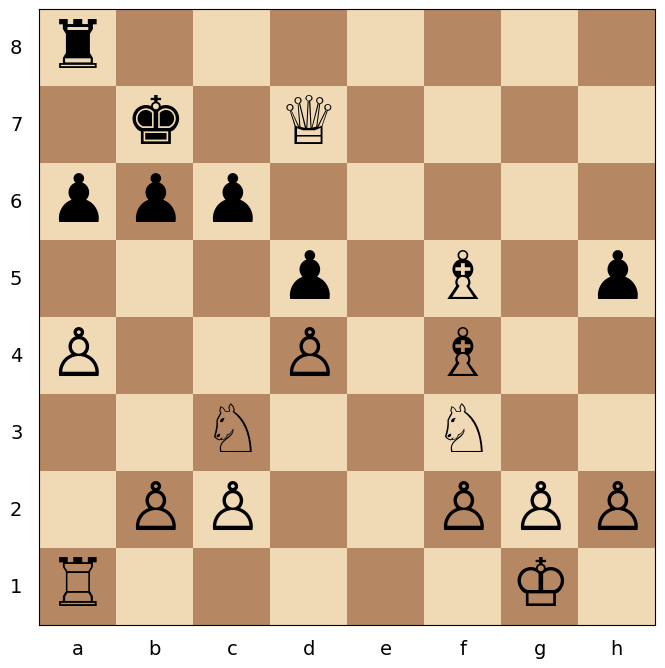

1-0


In [5]:
from IPython.display import clear_output
import chess

board = chess.Board()
probs = np.zeros((8, 8))
input_tensor = board_to_tensor(board)
plot_board(board)

while not board.is_game_over():
    user_move = input("Your move (e.g., e2e4): ")
    if user_move == "exit":
        break
    try:
        board.push_san(user_move)
    except Exception as e:
        print("Invalid move. Try again.")
        continue
    clear_output(wait=True)

    # Convert board to bitmap
    bitmaps = board_to_tensor(board)

    # Model predicts best move
    print(np.shape(bitmaps))
    probs = predict_move(input_tensor)
    best_square_idx = np.argmax(probs, keepdims=True)
    # Recebmos as classes dos moves: converter para moves e depois ordernar os moves por probabilidade
    moves = [REVERSE_MOVE_DICTIONARY[idx] for idx, prob in enumerate(probs)]
    best_moves = sorted(
        zip(moves, probs),
        key=lambda x: x[1], # Sort by probability
        reverse=True
    )

    for move in best_moves:
        try:
            board.push_uci(move[0])
            break
        except:
            continue

    # Convert board to bitmap
    bitmaps = board_to_tensor(board)
    plot_board(board)
print(board.result())